In [1]:
import pandas as pd  # For data tables
import numpy as np   # For math ops
import matplotlib.pyplot as plt  # For plots

Load the data 

In [2]:
df = pd.read_csv('../data/BrentOilPrices.csv')

# Convert Date to datetime (Python date format)
df['Date'] = pd.to_datetime(df['Date'])

# Show first 5 rows
df.head()

C:\Users\bezaw\AppData\Local\Temp\ipykernel_16968\1492298790.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Basic stats

In [7]:
df.describe()  # Shows mean, min, max, etc. for Price

,Date,Price
count,9011,9011.000000
mean,2005-02-10 23:46:53.760958,48.420782
min,1987-05-20 00:00:00,9.100000
25%,1996-03-20 12:00:00,19.050000
50%,2005-02-02 00:00:00,38.570000
75%,2014-01-09 12:00:00,70.090000
max,2022-11-14 00:00:00,143.950000
std,NaN,32.860110


Plot the raw price series (visual EDA)

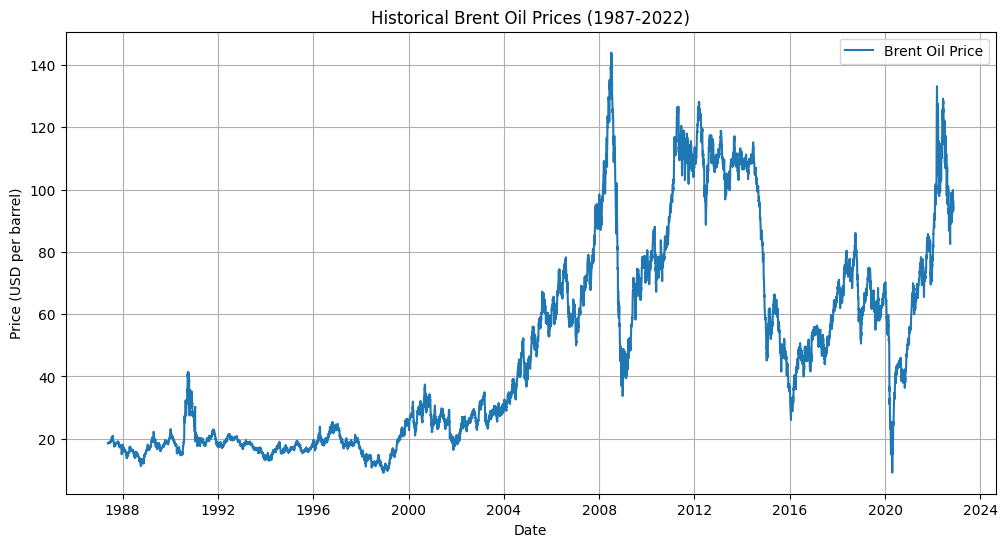

In [3]:
plt.figure(figsize=(12, 6))  # Make plot bigger
plt.plot(df['Date'], df['Price'], label='Brent Oil Price')
plt.title('Historical Brent Oil Prices (1987-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid(True)
plt.show()

Compute log returns (daily % changes, help with volatility)

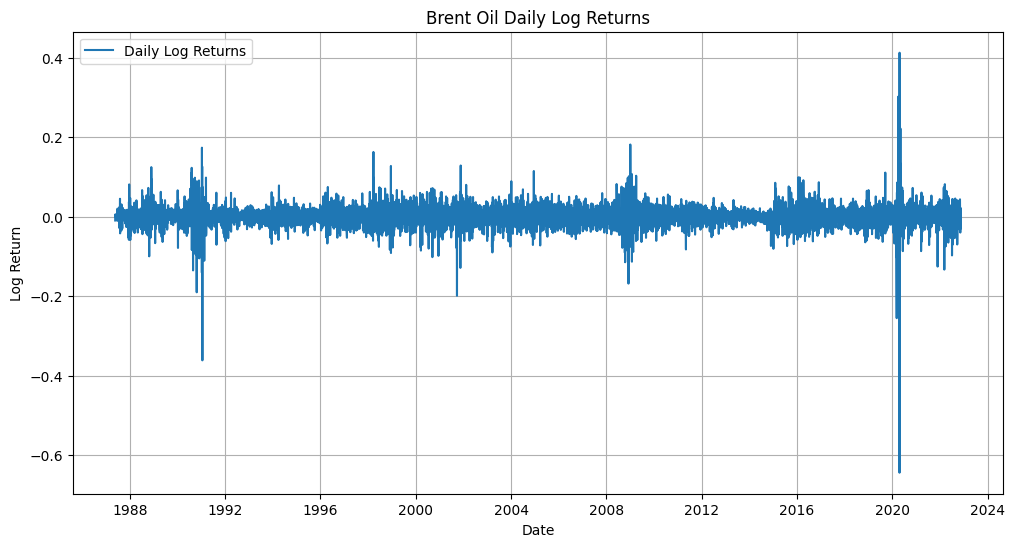

In [4]:
df['Log_Price'] = np.log(df['Price'])  # Log transform for stability
df['Log_Return'] = df['Log_Price'] - df['Log_Price'].shift(1)  # Difference for returns

# Plot log returns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Log_Return'], label='Daily Log Returns')
plt.title('Brent Oil Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

# Drop first row (NaN from shift)
df = df.dropna()

Import for tests

In [6]:
from statsmodels.tsa.stattools import adfuller

# ADF on raw Price
result_price = adfuller(df['Price'])
print('ADF on Price:')
print(f'ADF Statistic: {result_price[0]}')
print(f'p-value: {result_price[1]}')
print(f'Critical Values: {result_price[4]}')

# ADF on Log Returns (should be stationary)
result_returns = adfuller(df['Log_Return'])
print('\nADF on Log Returns:')
print(f'ADF Statistic: {result_returns[0]}')
print(f'p-value: {result_returns[1]}')
print(f'Critical Values: {result_returns[4]}')

ADF on Price:
ADF Statistic: -1.991854407129524
p-value: 0.29015603926422207
Critical Values: {'1%': np.float64(-3.4310784153953295), '5%': np.float64(-2.8618619122481883), '10%': np.float64(-2.566941348864837)}

ADF on Log Returns:
ADF Statistic: -16.42711349448589
p-value: 2.4985801611428892e-29
Critical Values: {'1%': np.float64(-3.4310783342658615), '5%': np.float64(-2.861861876398633), '10%': np.float64(-2.566941329781918)}


Compute and plot rolling colatility (30-day window)

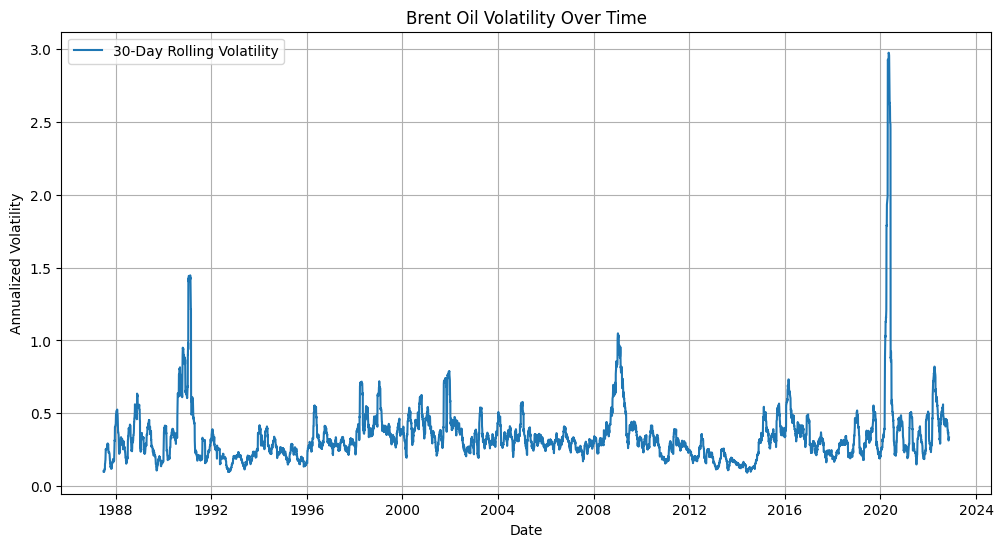

In [7]:
df['Volatility'] = df['Log_Return'].rolling(window=30).std() * np.sqrt(252)  # Annualized for interpretability

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volatility'], label='30-Day Rolling Volatility')
plt.title('Brent Oil Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()

### Time Series Properties Summary
- **Trend Analysis**: The raw price series shows a long-term upward trend from ~$20 in 1987 to peaks over $140 in 2008, driven by demand growth and supply constraints. Post-2008, prices crashed due to recession, recovered to ~$100 by 2014, then fell to ~$30 in 2016 (shale boom/OPEC). Recent: Dip to negative in 2020 (COVID), surge to $120+ in 2022 (Ukraine war). This non-linear trend suggests structural breaks from events.
- **Stationarity**: Raw prices are non-stationary (ADF p-value >0.05), meaning mean/variance change over time—can't assume stability for modeling. Log returns are stationary (p<0.05), so we'll use them for change point detection to avoid spurious results.
- **Volatility Patterns**: Shows clustering—periods of high volatility (e.g., 2008 crisis, 2014-16 crash, 2020 COVID) where swings amplify. This informs modeling: Change point models can detect shifts in mean/vol, and Bayesian handles uncertainty in volatile data.
- **How These Inform Modeling**: Non-stationarity → Use differenced data (log returns). Volatility clustering → Consider models like GARCH if extending, but for Bayesian change point, focus on mean shifts. Subset to 2012-2022 for "past decade" focus.

In [8]:
# Cell 8: Create events DataFrame and save to CSV
events = [
    {'Date': '2014-06-01', 'Description': 'ISIS insurgency in Iraq and Syria disrupts oil production', 'Category': 'Geopolitical'},
    {'Date': '2014-11-27', 'Description': 'OPEC decides not to cut production amid US shale boom', 'Category': 'OPEC'},
    {'Date': '2015-07-14', 'Description': 'Iran nuclear deal (JCPOA) signed', 'Category': 'Geopolitical'},
    {'Date': '2016-01-16', 'Description': 'Lifting of international sanctions on Iran', 'Category': 'Geopolitical'},
    {'Date': '2016-11-30', 'Description': 'OPEC+ agrees to production cuts of 1.8M bpd', 'Category': 'OPEC'},
    {'Date': '2018-05-08', 'Description': 'US withdraws from Iran nuclear deal and reimposes sanctions', 'Category': 'Geopolitical'},
    {'Date': '2019-09-14', 'Description': 'Drone attacks on Saudi Aramco facilities', 'Category': 'Geopolitical'},
    {'Date': '2020-01-03', 'Description': 'US drone strike kills Iranian General Soleimani', 'Category': 'Geopolitical'},
    {'Date': '2020-03-06', 'Description': 'OPEC+ price war begins after Saudi-Russia disagreement', 'Category': 'OPEC'},
    {'Date': '2020-03-11', 'Description': 'COVID-19 declared a pandemic, global demand collapse', 'Category': 'Economic'},
    {'Date': '2020-04-12', 'Description': 'OPEC+ agrees to historic cuts of 9.7M bpd', 'Category': 'OPEC'},
    {'Date': '2021-07-18', 'Description': 'OPEC+ eases production cuts amid recovery', 'Category': 'OPEC'},
    {'Date': '2022-02-24', 'Description': 'Russia invades Ukraine, supply fears', 'Category': 'Geopolitical'},
    {'Date': '2022-03-08', 'Description': 'US bans Russian oil imports', 'Category': 'Geopolitical'},
    {'Date': '2022-06-02', 'Description': 'EU partial embargo on Russian oil', 'Category': 'Geopolitical'}
]

events_df = pd.DataFrame(events)
events_df.to_csv('../data/oil_events.csv', index=False)
print(events_df.head())

         Date                                        Description      Category
0  2014-06-01  ISIS insurgency in Iraq and Syria disrupts oil...  Geopolitical
1  2014-11-27  OPEC decides not to cut production amid US sha...          OPEC
2  2015-07-14                   Iran nuclear deal (JCPOA) signed  Geopolitical
3  2016-01-16         Lifting of international sanctions on Iran  Geopolitical
4  2016-11-30        OPEC+ agrees to production cuts of 1.8M bpd          OPEC
